# Non LLM Based

## Cricket Batsman

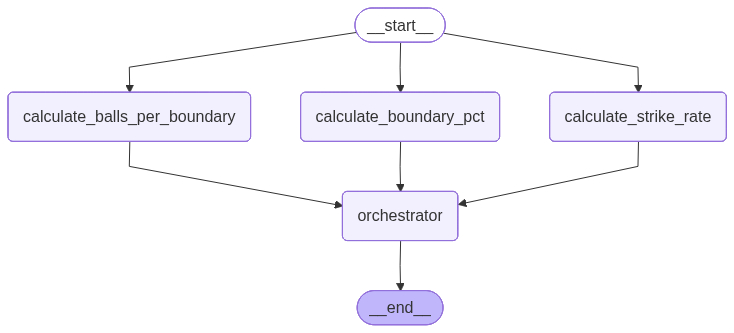


    Strike Rate : 300.0
    Balls Per Boundary : 5.0
    Boundary Percent : 32.0
    


In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict,List, Dict, Any

# Define a State
class BatsmanState(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int

    strike_rate: float
    balls_per_boundary: float
    boundary_pct: float
    summary: str | None

    # orchestrator inbox
    messages: List[Dict[str, Any]]

# Define Tasks -> functions
def calculate_strike_rate(state: BatsmanState):
    strike_rate = (state['runs']/state['balls']) * 100
    return  {'strike_rate': strike_rate}

def calculate_balls_per_boundary(state: BatsmanState):
    balls_per_boundary = state['balls']/(state['fours']+state['sixes'])
    return  {'balls_per_boundary': balls_per_boundary}

def calculate_boundary_pct(state: BatsmanState):
    boundary_pct = (((state['fours'] * 4)+(state['sixes'] * 6))/state['runs'])*100
    return {'boundary_pct': boundary_pct}

# Orchestrator / message router
def orchestrate_and_summarize(state: BatsmanState):
    updates = {}

    for msg in state.get("messages", []):
        updates[msg["type"]] = msg["value"]

    # merge with existing values
    strike_rate = updates.get("strike_rate", state.get("strike_rate"))
    balls_per_boundary = updates.get(
        "balls_per_boundary", state.get("balls_per_boundary")
    )
    boundary_pct = updates.get("boundary_pct", state.get("boundary_pct"))

    if None in (strike_rate, balls_per_boundary, boundary_pct):
        return {
            "strike_rate": strike_rate,
            "balls_per_boundary": balls_per_boundary,
            "boundary_pct": boundary_pct,
        }

    summary = f"""
    Strike Rate : {strike_rate}
    Balls Per Boundary : {balls_per_boundary}
    Boundary Percent : {boundary_pct}
    """

    return {
        "strike_rate": strike_rate,
        "balls_per_boundary": balls_per_boundary,
        "boundary_pct": boundary_pct,
        "summary": summary
    }

# Define the graph
graph = StateGraph(BatsmanState)

# Add nodes to graph
graph.add_node('calculate_strike_rate', calculate_strike_rate)
graph.add_node('calculate_balls_per_boundary', calculate_balls_per_boundary)
graph.add_node('calculate_boundary_pct', calculate_boundary_pct)
graph.add_node("orchestrator", orchestrate_and_summarize)


# Add edges to graph
graph.add_edge(START, 'calculate_strike_rate')
graph.add_edge(START, 'calculate_balls_per_boundary')
graph.add_edge(START, 'calculate_boundary_pct')

graph.add_edge('calculate_strike_rate', 'orchestrator')
graph.add_edge('calculate_balls_per_boundary', 'orchestrator')
graph.add_edge('calculate_boundary_pct', 'orchestrator')

graph.add_edge('orchestrator', END)

# Compile the graph
orchestrator_workflow = graph.compile()
display(orchestrator_workflow)

# Execute the graph
initial_state = {
    "runs": 150,
    "balls": 50,
    "fours": 6,
    "sixes": 4,

    "strike_rate": None,
    "balls_per_boundary": None,
    "boundary_pct": None,
    "summary": None,

    "messages": []
}

final_state = orchestrator_workflow.invoke(initial_state)
print(final_state["summary"])

